In [1]:
import requests
import json
import pandas as pd
import xmltodict as xtd
from wordcloud import WordCloud

In [2]:
# 2009 toxrefdb pmids: 19363143,19337514
def get_cited(ids=[]):
    """input a list of pubmed identifiers"""
    params = {
        "retmode":"json",
        "id":ids,
        "dbfrom":"pubmed",
        "linkname":"pubmed_pubmed_citedin"
    }
    url = """https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi"""
    r = json.loads(requests.get(url,params).content)
    links = set()
    for ls in r["linksets"]:
        if ls["dbfrom"]=="pubmed":
            for lsdb in ls["linksetdbs"]:
                if lsdb["dbto"]=="pubmed":
                    links|=set(lsdb["links"])
    return list(links)

In [3]:
def get_article_info(pmids):
    url = """https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"""
    params = {
        "db":"pubmed",
        "id":pmids,
        "retmode":"xml"
    }
    return xtd.parse(requests.get(url,params).content,force_list=["PublicationType","MeshHeading","AbstractText"])

In [4]:
r = get_article_info(get_cited([19363143,19337514]))

In [5]:
dfs = []
for a in r["PubmedArticleSet"]["PubmedArticle"]:
    pmid = a["MedlineCitation"]["PMID"]["#text"]
    title = a["MedlineCitation"]["Article"]["ArticleTitle"]
    abstract = " "
    if "Abstract" in a["MedlineCitation"]["Article"]:
        for t in a["MedlineCitation"]["Article"]["Abstract"]["AbstractText"]:
            if "#text" in t:
                abstract+=t["#text"]+" "
    journal = a["MedlineCitation"]["Article"]["Journal"]["Title"]
    publication_types = [pt["#text"] for pt in a["MedlineCitation"]["Article"]["PublicationTypeList"]["PublicationType"]]
    mesh_terms = [m["DescriptorName"]["#text"] for m in a["MedlineCitation"]["MeshHeadingList"]["MeshHeading"]] if "MeshHeadingList" in a["MedlineCitation"] else [None]
    mesh_uis = [m["DescriptorName"]["@UI"] for m in a["MedlineCitation"]["MeshHeadingList"]["MeshHeading"]] if "MeshHeadingList" in a["MedlineCitation"] else [None]
        
    dfs.append(pd.DataFrame({"pmid":pmid,"title":title,"journal":journal,"abstract":abstract},index=[pmid]).merge(
        pd.DataFrame({"pmid":[pmid]*len(publication_types),"publication_types":publication_types},index=[pmid]*len(publication_types))).merge(
            pd.DataFrame({"pmid":[pmid]*len(mesh_terms),"mesh_term":mesh_terms,"mesh_ui":mesh_uis},index=[pmid]*len(mesh_terms))))


In [6]:
df = pd.concat(dfs)

In [7]:
writer = pd.ExcelWriter("toxrefdb_cited_articles.xlsx")
pd.DataFrame(df[["pmid","title","journal","publication_types"]].drop_duplicates().groupby(["pmid","title","journal"]).publication_types.apply(lambda x: "|".join(x))).to_excel(writer)
writer.save()

In [21]:
with open("toxref_word_cloud.txt","w",encoding="utf8") as words:
    for x in df.mesh_term.values:
        if x is not None:
            words.write(x.title()+" ")
#             print(x.title())
    for x in df.title.unique():
        if isinstance(x,float):
            words.write(" ")
        else:
            words.write(x.title()+" ")
#         print(x.title())
    for x in df.abstract.unique():
        words.write(x.title()+" ")
#         print(x.title())

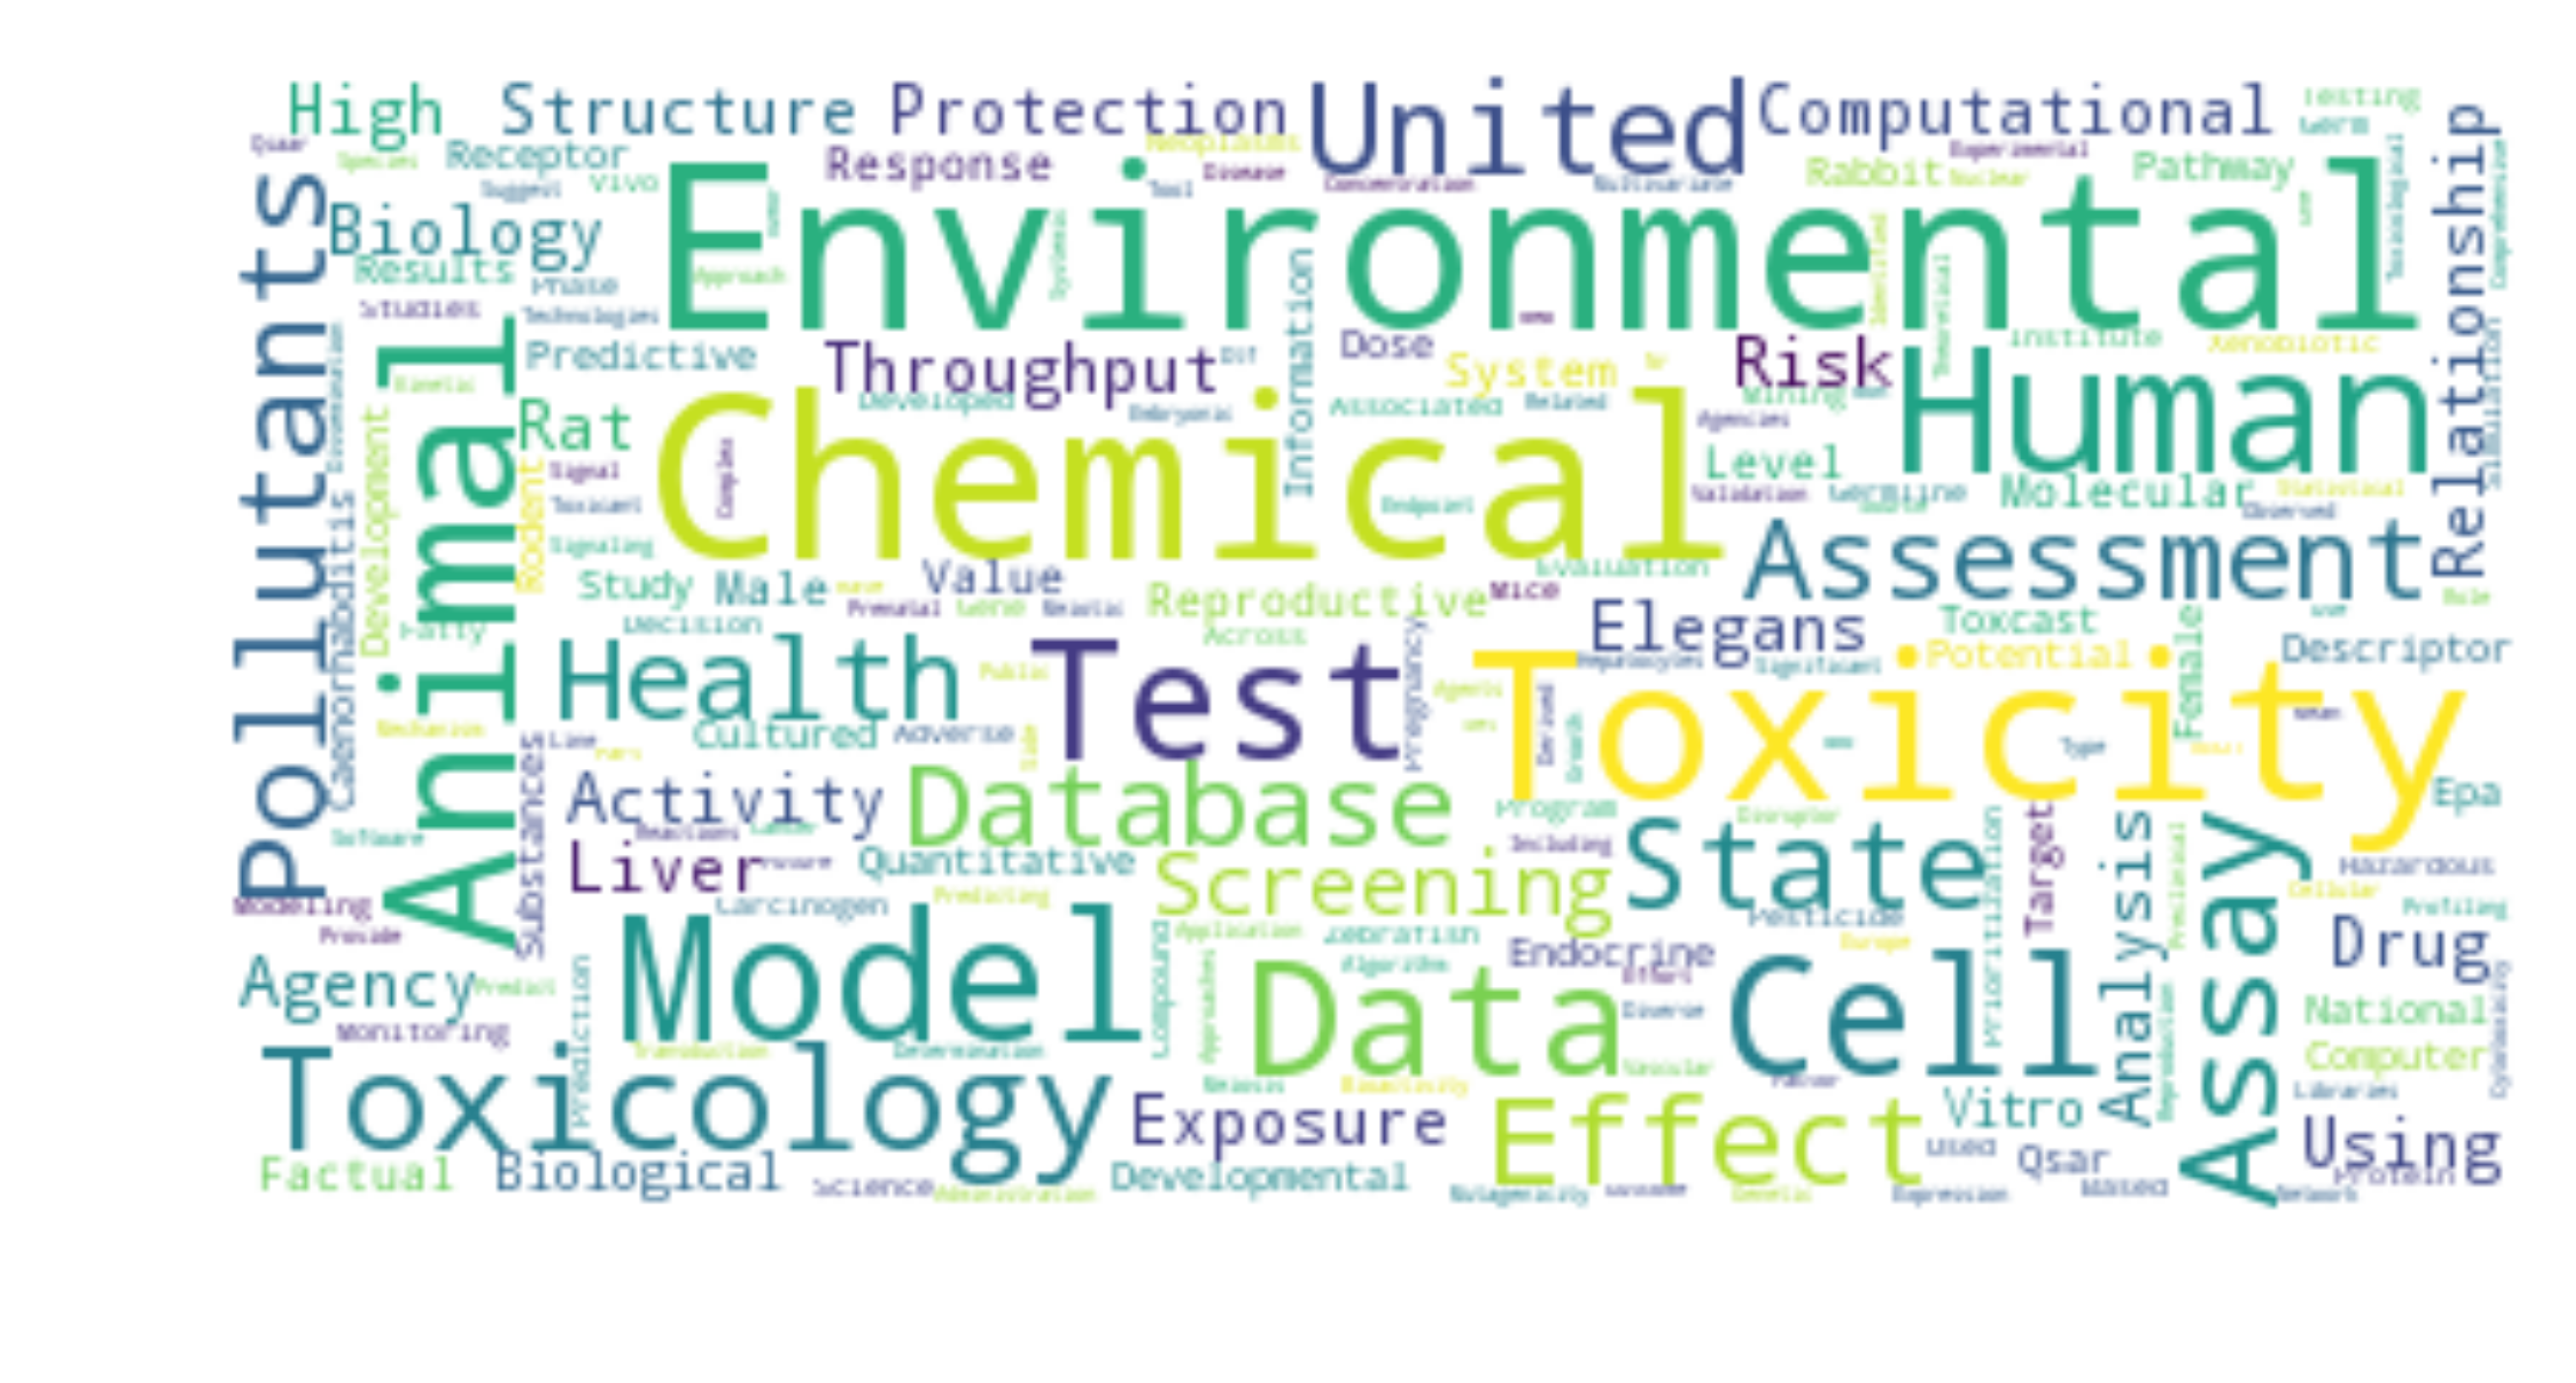

In [22]:
import matplotlib.pyplot as plt
# plt.imshow(wc, interpolation='bilinear')
# plt.axis("off")

# lower max_font_size
wc = WordCloud(max_font_size=40,
               background_color="white",
               collocations=False).generate(open("toxref_word_cloud.txt").read())
plt.figure(dpi=500)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("toxref_wordcloud.jpeg",dpi=1000,transparent=True,bbox_inches="tight")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()